In [165]:
import random
import json
import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.metrics import edit_distance
from transformers import AutoTokenizer

random.seed(6)
np.random.seed(6)


# week 02-24: Checking the bias in the dataset

In this experiment we prompt the model to answer the question without providing the Spatio-Temporal Scene Graph.


**Parameters:**
- system prompt: system_prompt_bias_check.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)
- the output is limited to 128 tokens (shouldn't influence the results, it only cutoffs the generation)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [166]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,choices,num,text
id,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...
Feasibility_T6_1453,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


Loading the responses from the LLM

In [167]:
# needed to modify the output file because of the bug
# I introduced in the code
predictions = []
with open('../outputs/bias_check_responses_llama3.2_20250227_14:14:30.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,answer
id,
Interaction_T1_13,"To answer this question, I need to consider wh..."
Interaction_T1_14,"To answer this question, I need to consider wh..."
Interaction_T1_31,"To determine which object was thrown, I need t..."
Interaction_T1_32,"To answer this question, I need to consider wh..."
Interaction_T1_40,"To answer this question, I need to consider wh..."
...,...
Feasibility_T6_1453,"To answer this question, let's analyze the sit..."
Feasibility_T6_1454,"To answer this question, let's think step by s..."
Feasibility_T6_1455,"To answer this question, let's consider what t..."


In [168]:
predictions_df.iloc[0:20]['answer'].apply(print)


To answer this question, I need to consider which object is most likely to be tidied up by a person. 

Tidying up typically involves organizing and arranging objects in a way that makes them easier to use or access. Among the options provided, "The clothes" stands out as the most likely candidate for tidying up. This is because people often sort, fold, and put away their clothes to keep their closet organized.

Therefore, my reasoning leads me to choose option 2: The clothes.
To answer this question, I need to consider which object is most likely to be tidied up by a person. 

Tidying up typically involves organizing and arranging objects in a way that makes them easier to use or access. Among the options provided, "The clothes" stands out as the most likely candidate for tidying up. This is because people often sort, fold, and put away their clothes to keep their closet organized.

Therefore, I choose:

A: 2. The clothes.
To determine which object was thrown, I need to consider the co

id
Interaction_T1_13     None
Interaction_T1_14     None
Interaction_T1_31     None
Interaction_T1_32     None
Interaction_T1_40     None
Interaction_T1_43     None
Interaction_T1_70     None
Interaction_T1_71     None
Interaction_T1_76     None
Interaction_T1_78     None
Interaction_T1_81     None
Interaction_T1_95     None
Interaction_T1_100    None
Interaction_T1_101    None
Interaction_T1_104    None
Interaction_T1_106    None
Interaction_T1_111    None
Interaction_T1_137    None
Interaction_T1_139    None
Interaction_T1_147    None
Name: answer, dtype: object

Let's start by viewing how many answers follow the template:

In [169]:
# Check if the the template is somewhere in the answer
#
# An example of the template expressed by the regex is: A: 1. The answer.
# where the number followed by a dot is optional
ans_regex_pattern = r'A:\s*(?:\d\.)?\s*((?:(?:\b(?:\w\/?)+\b\s?)+){1,10}\.)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 6809
95.93% of the total

Only 289 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_292839/2441139152.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


In [170]:
# Note: to access meta-llama you have to first accept the licence agreement
hugg_key = os.environ['HUGGINGFACE_KEY']

tokenizer = AutoTokenizer.from_pretrained(
                'meta-llama/Llama-3.2-3B-Instruct', 
                token=hugg_key)


In [171]:
resp_token_len = pd.Series(index=predictions_df.index)

for index, row in predictions_df.iterrows():
    resp_token_len.loc[index] = len(tokenizer.encode(row['answer']))

resp_token_len.sort_values().value_counts(sort=False)


/tmp/ipykernel_292839/4005420109.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  resp_token_len = pd.Series(index=predictions_df.index)


26.0      1
32.0      3
44.0      1
51.0      3
52.0      1
         ..
352.0     1
356.0     1
378.0     1
482.0     1
8193.0    2
Length: 255, dtype: int64

## Distribution of generated response lengths measured in tokens

count    7098.000000
mean      152.253452
std       143.079173
min        26.000000
25%       111.000000
50%       148.000000
75%       183.000000
max      8193.000000
dtype: float64

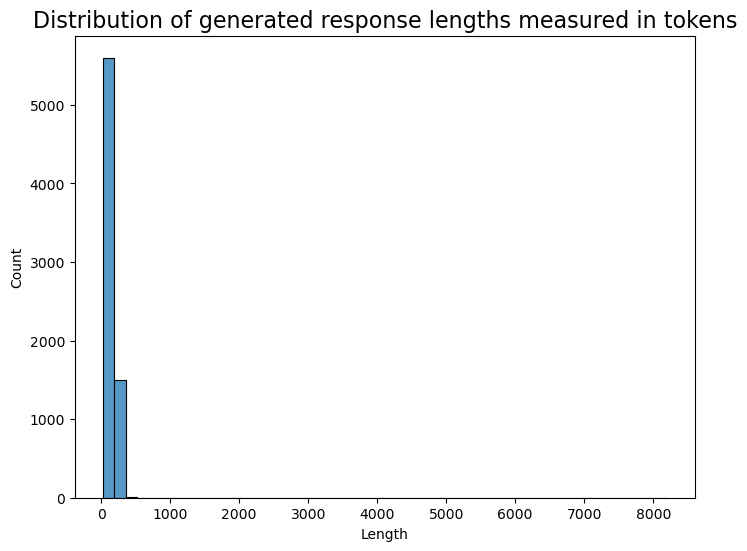

In [172]:
plt.figure(figsize=(8, 6))
sns.histplot(resp_token_len, bins=50)
plt.title("Distribution of generated response lengths measured in tokens", fontsize=16)
plt.xlabel("Length")
plt.ylabel("Count")

resp_token_len.describe()


## Extracting the answers

Let's extract the the answers from the generated texts which do contain an answer:

In [173]:
ans_df = predictions_df.loc[contains_answer]['answer'].str.extract(ans_regex_pattern)
ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T1_14,The clothes.
Interaction_T1_31,The pillow.
Interaction_T1_32,The shoe.
Interaction_T1_40,The closet/cabinet.
Interaction_T1_43,The pillow.
...,...
Feasibility_T6_1453,Put down the phone/camera.
Feasibility_T6_1454,Throw the bag.
Feasibility_T6_1455,Take the shoe.


In [174]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 414 unique answers


In [175]:
ans_df['text'].value_counts()


Put down.                  433
The bag.                   335
The cup/glass/bottle.      312
Took.                      311
The clothes.               233
                          ... 
Throw the blanket.           1
Lie on the bed.              1
Hold the mirror.             1
Tidy up the towel.           1
Close the refrigerator.      1
Name: text, Length: 207, dtype: Int64

<AxesSubplot: xlabel='freq', ylabel='word'>

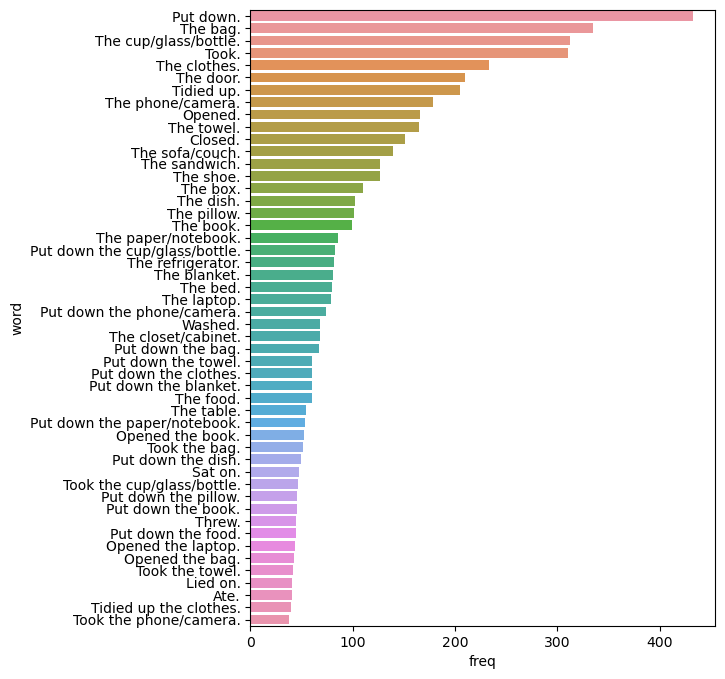

In [176]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [177]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


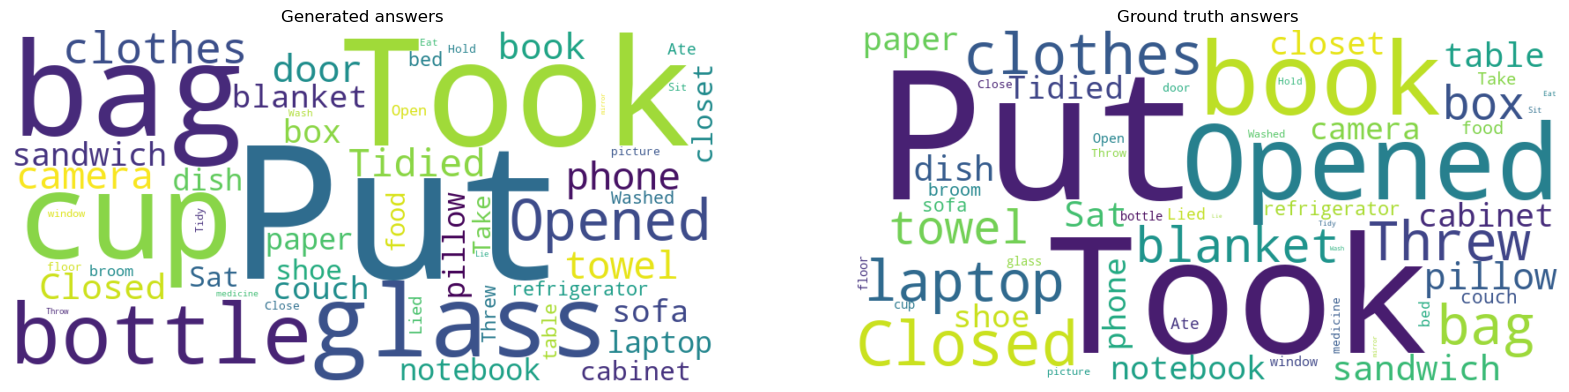

In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# predictions worldcloud
pred_text = ' '.join(ans_df['text'].astype(str))
wordcloud1 = WordCloud(width=800,
                       height=400,
                       background_color='white',
                       collocations=False).generate(pred_text)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Generated answers')

# ground truth wordcloud 
gt_text = ' '.join(gt_df['text'].astype(str))
wordcloud2 = WordCloud(width=800,
                       height=400,
                       background_color='white', 
                       collocations=False).generate(gt_text)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Ground truth answers')

plt.show()


<AxesSubplot: xlabel='freq', ylabel='word'>

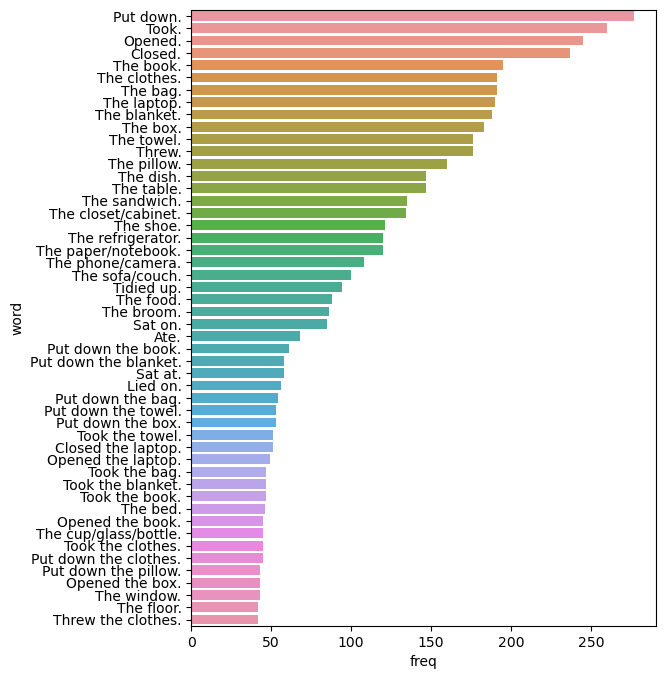

In [179]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [180]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(6809, 4)

In [181]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'] == eval_df[on_what]).sum()
    

    return hits_text/eval_df.shape[0]


In [182]:
text_acc = accuracy(eval_df)

print(f"Text Accuracy: {text_acc:.2%}")


Text Accuracy: 28.58%


In [183]:
eval_df[eval_df['text'] == eval_df['pred_text']]


,choices,num,text,pred_text
id,,,,
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.,The shoe.
Interaction_T1_40,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.,The closet/cabinet.
Interaction_T1_70,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.,The shoe.
Interaction_T1_76,"{'0': 'The shoe.', '1': 'The clothes.', '2': '...",2,The pillow.,The pillow.
...,...,...,...,...
Feasibility_T6_1298,"{'0': 'Close the box.', '1': 'Put down the cup...",1,Put down the cup/glass/bottle.,Put down the cup/glass/bottle.
Feasibility_T6_1304,"{'0': 'Open the closet/cabinet.', '1': 'Put do...",2,Put down the broom.,Put down the broom.
Feasibility_T6_1370,"{'0': 'Tidy up the blanket.', '1': 'Open the b...",1,Open the box.,Open the box.


check if the equality with NA result in a false or is skipped

In [184]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 27.42%


In [185]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [186]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         2252        26.64%  
Sequence            3482        30.33%  
Prediction           604        26.49%  
Feasibility          471        27.60%  


In [187]:
# % of answers conforming to the template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        93.91%  
Sequence            3586        97.10%  
Prediction           624        96.79%  
Feasibility          490        96.12%  
Overall             7098        95.93%  
